## Fake News Prediction – 

Recently there has been a topic of fake news detection on social media, where lots of posts are getting published by many companies and daily basis and in order to identify if there is a fake news or not its not very easy, so with help of Machine learning, we will develop a solution which can identify if this is a fake news or not.

# Import Libraries

In [471]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.metrics import roc_curve

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [472]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Datasets

In [473]:
dftrain = pd.read_csv('./Data/train.csv')
dftest = pd.read_csv('./Data/test.csv')
dfsubmit = pd.read_csv('./Data/submit.csv')

# 1. Data Wrangling - 

Share and Dimension on datasets - 

In [474]:
print("Shape of train dataset - ", dftrain.shape)
print("Shape of test dataset - ", dftest.shape)

Shape of train dataset -  (20800, 5)
Shape of test dataset -  (5200, 4)


In [475]:
dftrain.head(2)

id                                              title           author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...    Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...  Daniel J. Flynn   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0

In [476]:
dftest.head(2)

id                                              title            author  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...  David Streitfeld   
1  20801  Russian warships ready to strike terrorists ne...               NaN   

                                                text  
0  PALO ALTO, Calif.  —   After years of scorning...  
1  Russian warships ready to strike terrorists ne...

In [477]:
dftrain['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [478]:
print('Train Dataset')
print(dftrain.dtypes)
print()
print('Test Dataset')
print(dftest.dtypes)

Train Dataset
id         int64
title     object
author    object
text      object
label      int64
dtype: object

Test Dataset
id         int64
title     object
author    object
text      object
dtype: object


From the above results we can see that there are 10413 articles marked as legit news and 10387 articles are marked as Fake News.

### Drop the ID column -

In [479]:
dftrain.drop('id', axis=1, inplace=True)
dftest.drop('id', axis =1, inplace = True)

### Find the null values in datasets

In [480]:
dftrain.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [481]:
dftest.isna().sum()

title     122
author    503
text        7
dtype: int64

In [482]:
# Percentage of missing value columns
print(dftrain.isna().sum()/len(dftrain)*100)

title     2.682692
author    9.408654
text      0.187500
label     0.000000
dtype: float64


In [483]:
# Percentage of missing value columns
dftest.isna().sum()/len(dftest)*100

title     2.346154
author    9.673077
text      0.134615
dtype: float64

## Data PreProcessing

Below steps will be performing for the text - Data Preprocessing

1. Remove Line Breaks element
2. Remove NewLine element
3. Remove Hyperlink element
4. Remove Ampersand 
5. Remove greater than sign
6. Remove less than sign
7. Remove non-breaking space 
8. Remove Emails
9. Remove new line characters
10. Remove distracting single quotes

In [484]:
def preprocessdata(article_text):
    
    article_text = article_text.str.replace("(<br/>)", "")
    
    article_text = article_text.str.replace("(\n)", "")
    
    article_text = article_text.str.replace('(<a).*(>).*(</a>)', '')
    
    article_text = article_text.str.replace('(&amp)', '')
    
    article_text = article_text.str.replace('(&gt)', '')
    
    article_text = article_text.str.replace('(&lt)', '')
    
    article_text = article_text.str.replace('(\xa0)', ' ')  
    
    article_text = [re.sub(r"\S*@\S*\s?", '', str(sent)) for sent in article_text]
    
    article_text = [re.sub(r"\s+", ' ', sent) for sent in article_text]
    
    article_text = [re.sub("\'", "", sent) for sent in article_text]
    
    return article_text

### Data Processing on Train Data

In [485]:
# Bring Label in front to view data nicely
first_column = dftrain['label']
dftrain.drop('label', axis=1,inplace=True)
dftrain.insert(0, 'label', first_column)
dftrain.head()

label                                              title  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  
0       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...  
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...  
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...  
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...  
4      Howard Portnoy  Print \nAn Iranian woman has been sentenced to...

In [486]:
# Preprocess the train data by calling function
dftrain['text'] = preprocessdata(dftrain['text'])

In [487]:
dftrain.head(2)

label                                              title           author  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...    Darrell Lucus   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...  Daniel J. Flynn   

                                                text  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  Ever get the feeling your life circles the rou...

### Data Processing on Test Data

In [488]:
# Preprocess the test data by calling function
dftest['text'] = preprocessdata(dftest['text'])

In [489]:
dftest.head(2)

title            author  \
0  Specter of Trump Loosens Tongues, if Not Purse...  David Streitfeld   
1  Russian warships ready to strike terrorists ne...               NaN   

                                                text  
0  PALO ALTO, Calif. — After years of scorning th...  
1  Russian warships ready to strike terrorists ne...

### Create a column with Length of Text Column

In [490]:
# Calculate the length of text column
dftrain['textlen'] = dftrain["text"].str.len()

In [491]:
dftrain.head(2)

label                                              title           author  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...    Darrell Lucus   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...  Daniel J. Flynn   

                                                text  textlen  
0  House Dem Aide: We Didn’t Even See Comey’s Let...     4886  
1  Ever get the feeling your life circles the rou...     4143

### Plot for Null Values in Train Dataset

author     1957
title       558
textlen       0
text          0
label         0
dtype: int64


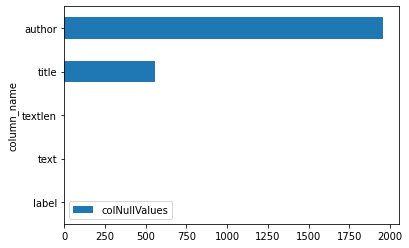

In [492]:
# Bar plot for null values for each attribute
dfNull = pd.DataFrame(columns=['column_name', 'colNullValues'])
dfNull['column_name'] = dftrain.columns
dfNull['colNullValues'] = dftrain.isnull().sum().values
dfNull.sort_values(by=['colNullValues'], ascending=True, inplace=True)
dfNull.plot(x='column_name', y='colNullValues', kind='barh')
print(dftrain.isnull().sum().sort_values(ascending=False))
plt.show()

Three Attributes has the null values - Author, Title and Text. 

* Around 1957 records are null for Author

* Around 558 records are null for Title

### Fill the Null values for Author and Title

In [493]:
values = {'author' : 'NA', 'title': 'NA'}
dftrain.fillna(value=values, inplace=True)

In [494]:
dftrain.loc[dftrain['text'].isna()]

Empty DataFrame
Columns: [label, title, author, text, textlen]
Index: []

### Delete the text words which are less than 45

In [495]:
#Drop the records less then 10 Words
dftrain.drop(dftrain.loc[(dftrain['textlen'] <= 45)].index, inplace=True)

In [496]:
dftrain.dropna(inplace=True)

In [497]:
print(dftrain.shape)
dftrain.head(2)

(20563, 5)


label                                              title           author  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...    Darrell Lucus   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...  Daniel J. Flynn   

                                                text  textlen  
0  House Dem Aide: We Didn’t Even See Comey’s Let...     4886  
1  Ever get the feeling your life circles the rou...     4143

textlen    0
text       0
author     0
title      0
label      0
dtype: int64


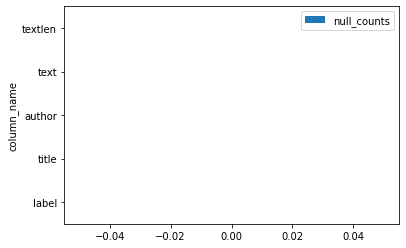

In [498]:
# Bar plot for null values for each attribute
null_df = pd.DataFrame(columns=['column_name', 'null_counts'])
null_df['column_name'] = dftrain.columns
null_df['null_counts'] = dftrain.isnull().sum().values
null_df.sort_values(by=['null_counts'], ascending=True, inplace=True)
null_df.plot(x='column_name', y='null_counts', kind='barh')
print(dftrain.isnull().sum().sort_values(ascending=False))
plt.show()

In [499]:
dftrain.isna().sum()

label      0
title      0
author     0
text       0
textlen    0
dtype: int64

### Create Length in Test Dataset

In [500]:
# # Calculate the length of text column
dftest['textlen'] = dftest["text"].str.len()

### Handle the Null values in Test Dataset for Author and Title

In [501]:
values = {'author' : 'NA', 'title': 'NA'}
dftest.fillna(value=values, inplace=True)

### Explore the data in Test Dataset

In [502]:
dftest.loc[(dftest['textlen'] == 0) & (dftest['text'] != ' ')]

Empty DataFrame
Columns: [title, author, text, textlen]
Index: []

In [503]:
dftest.loc[dftest['text'].isna()]

Empty DataFrame
Columns: [title, author, text, textlen]
Index: []

### Handle the NAN and Special Characters in Test Dataset

In [504]:
#dftest.drop(dftest.loc[(dftest['textlen'] <= 50)].index, inplace=True)

In [505]:
dftest.dropna(inplace=True)

In [506]:
print(dftest.shape)
dftest.head(2)

(5200, 4)


title            author  \
0  Specter of Trump Loosens Tongues, if Not Purse...  David Streitfeld   
1  Russian warships ready to strike terrorists ne...                NA   

                                                text  textlen  
0  PALO ALTO, Calif. — After years of scorning th...     7961  
1  Russian warships ready to strike terrorists ne...     1556

### Create the Corpus of Words as below from Train and Test Datasets

In [507]:
# Create corpus from text column from Train and Test Dataset
train_text_data = list(dftrain['text'])
test_text_data = list(dftest['text'])
corpuswhole = train_text_data + test_text_data

In [508]:
# Display the Corpus
corpuswhole

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emails 

## Create the Train and Test Dataset

In [509]:
# Split the dftrain dataset to Train and Test Dataset
y = dftrain['label']
X_train, X_test, y_train, y_test = train_test_split(dftrain['text'],y, test_size=0.3, random_state=40)

In [510]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [511]:
#TFidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [512]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# 2. Data Visualization

### Create the Sentiments Analysis

In [513]:
# Create the Sentiments score from the text column
dftrain['sentiment'] = dftrain['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
dftrain.head()

label                                              title  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print An Iranian woman has been sentenced to s...   

   textlen  sentiment  
0     4886   0.001796  
1     4143   0.100880  
2     7670   0.056258  
3     3223   0.017497  
4      934  -0.012500

## Distribution on Sentiments Score

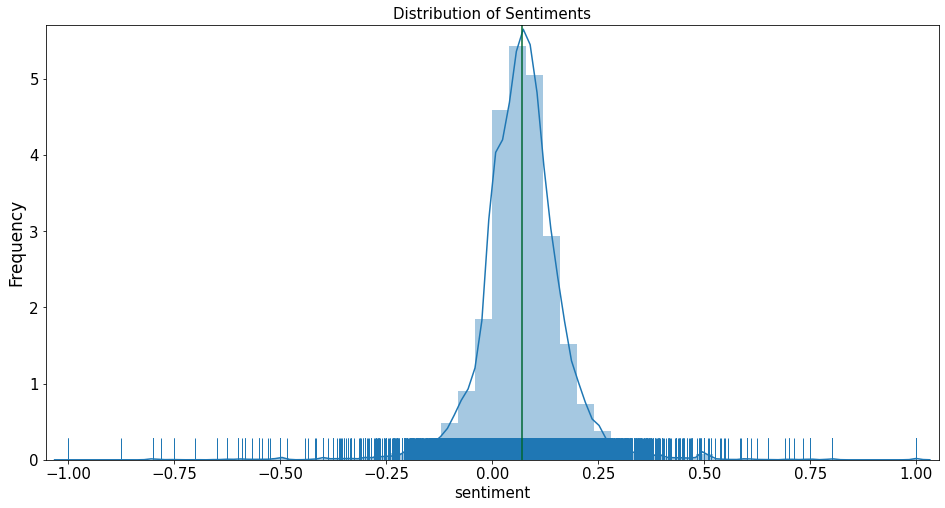

In [514]:
# Distribution plot for Sentiments Sore
plt.figure(figsize=(16,8))
plt.margins(0.01)
plt.xlabel('Sentiment', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Frequency', fontsize=17)
plt.yticks(fontsize=15)
#plt.hist(dftrain['sentiment'], bins=40)
sns.distplot(dftrain['sentiment'], kde=True, rug = True)
plt.axvline(dftrain['sentiment'].mean(), color='b',alpha=0.5)
plt.axvline(dftrain['sentiment'].median(), color='g',alpha=0.8)
plt.title('Distribution of Sentiments', fontsize=15)
plt.show()

Distribution of the sentiments score, it has close to normal distribution, as it seems, it has both positive and negative sentiments almost equally.

## Pie-Chart for Fake News Percentage from label

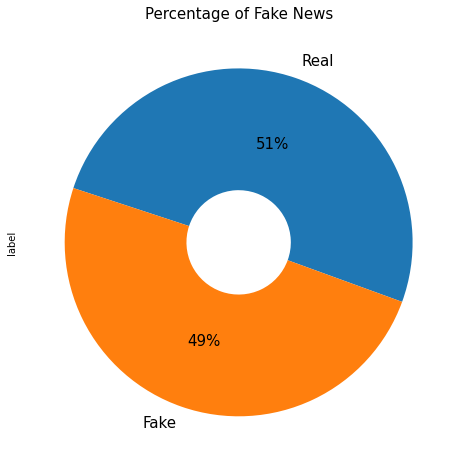

In [515]:
plt.figure(figsize=(12,8))
plt.title('Percentage of Fake News', fontsize=15)
dftrain.label.value_counts().plot(kind='pie', labels=['Real', 'Fake'],
                              wedgeprops=dict(width=.7),autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

## Correlation Matrix

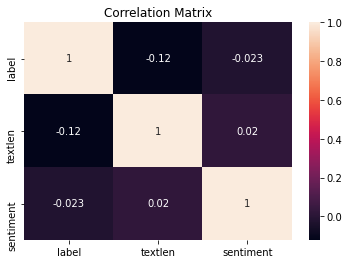

In [516]:
# Create a heatmap 
corr = dftrain.corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

correlation matrix, describing the relation between the attributes, the values of the correlation are between -1 and 1, showing positive and negative correlation. There is not strong correlation between any attributes, but there is a negative correlation of -0.12 between length and label.

## WordCloud from Corpus (Train + Test)

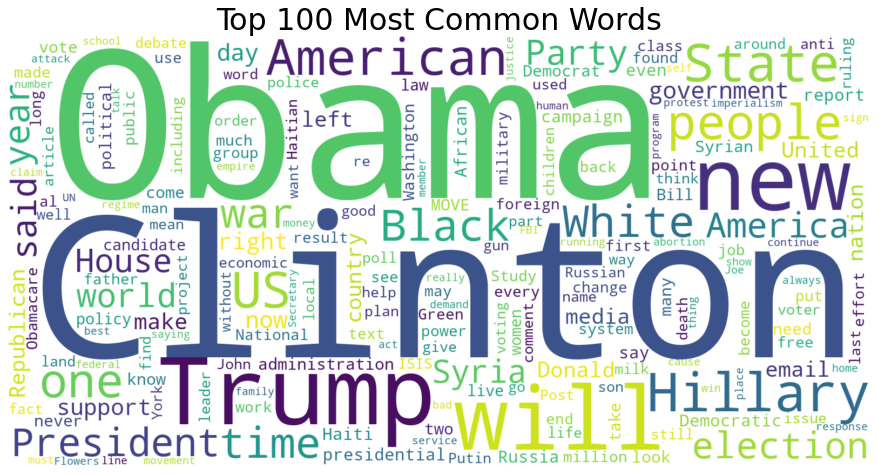

In [517]:
# WordCloud from the Corpus of 100 words
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(corpuswhole).most_common(100)
wordcloud = WordCloud(width=1600, height=800,collocations=False, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(12,8), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

## WordCloud from Train Dataset

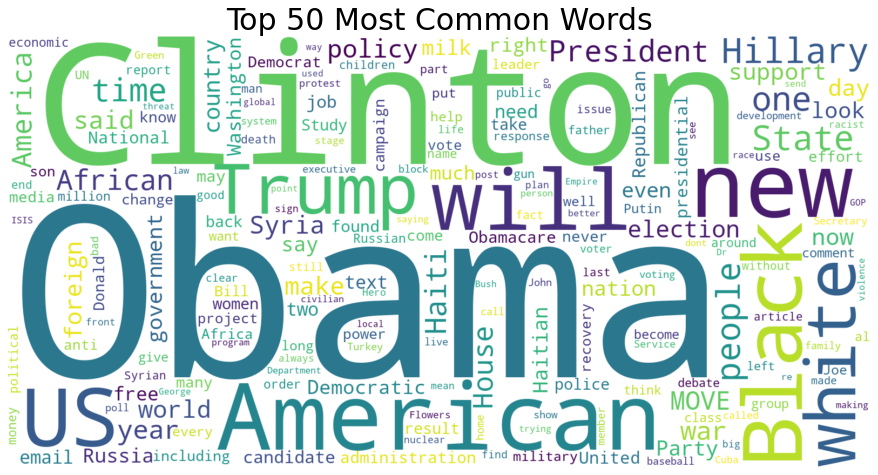

In [518]:
# WordCloud from the Train Dataset of 100 words
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(dftrain['text']).most_common(50)
wordcloud = WordCloud(width=1600, height=800,collocations=False, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(12,8), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

WordCloud from Train Dataset, creating the word cloud of 50 most common words are “Obama”, followed by “Clinton” and “American”.

## N-Gram Plots (UniGram, BiGram and TriGram)

In [519]:
def n_gramplot(corpus, n, m):
    vec = CountVectorizer(ngram_range=(m,m), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plotfigure(typeofgram1, typeofgram2, typeofgram3):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,8))
    df1 = pd.DataFrame(typeofgram1, columns=['uniword', 'count']) 
    ax1.set(ylabel='Count')
    df1.groupby('uniword').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                                 title='Top 20 words In Articles', ax=ax1)
    
    
    df2 = pd.DataFrame(typeofgram2, columns=['biword', 'count']) 
    ax2.set(ylabel='Count')
    df2.groupby('biword').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                                 title='Top 20 words In Articles', ax=ax2)
    
    df3 = pd.DataFrame(typeofgram3, columns=['triword', 'count']) 
    ax3.set(ylabel='Count')
    df3.groupby('triword').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                                 title='Top 20 words In Articles', ax=ax3)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.show()

In [520]:
uni_words_sw = n_gramplot(dftrain['text'], 20, 1)

In [521]:
bi_words_sw = n_gramplot(dftrain['text'], 20, 2)

In [522]:
tri_words_sw = n_gramplot(dftrain['text'], 20, 3)

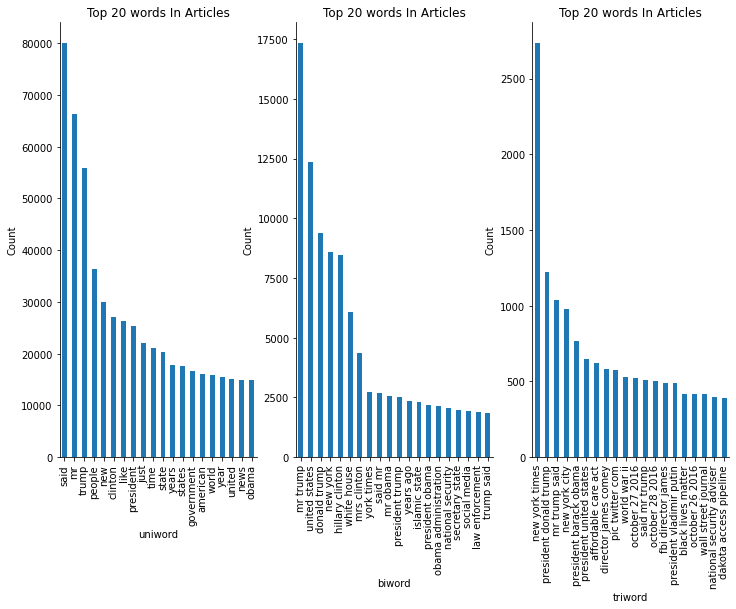

In [523]:
plotfigure(uni_words_sw, bi_words_sw, tri_words_sw)

Creating the n-Gram plots for Unigram, Bigram and Trigram, in the unigram, the most common words after stopword are “said”, “mr” and “trump”. In the Bigram, we can see “mr trump”, “united states” and “donald trump”. In the trigram, we can see the common words are “new york times”, “president Donald trump ” and “mr trump said”.

In [524]:
from wordcloud import WordCloud, STOPWORDS

WNL = nltk.WordNetLemmatizer()
#set the stopwords list
stopwords_wc = set(STOPWORDS)
customised_words = ['said', 'mr'] # If you want to remove any particular word form text which does not contribute much in meaning
new_stopwords = stopwords_wc.union(customised_words)


In [525]:
def n_gramplot_n(corpus, n, m):
    vec = CountVectorizer(ngram_range=(m,m), stop_words=new_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  sorted(inconsistent))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  sorted(inconsistent))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: Us

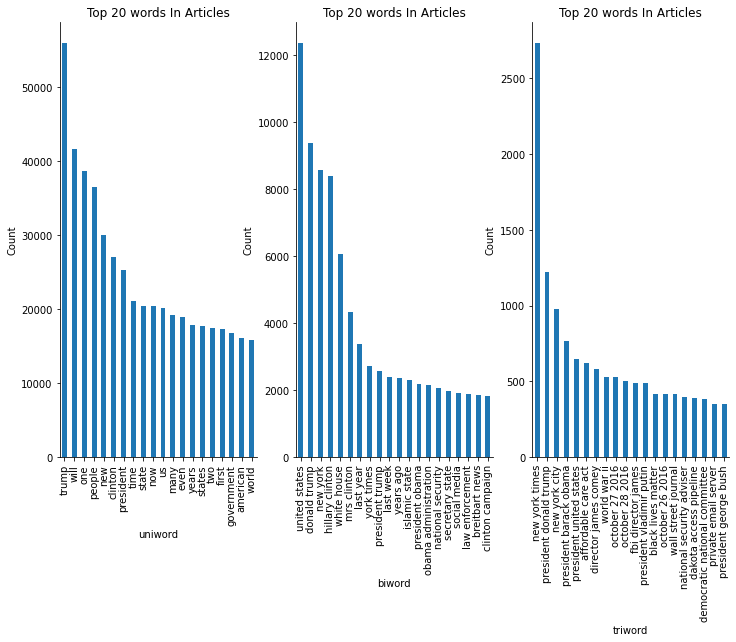

In [526]:
uni_words_sw_n = n_gramplot_n(dftrain['text'], 20, 1)
bi_words_sw_n = n_gramplot_n(dftrain['text'], 20, 2)
tri_words_sw_n = n_gramplot_n(dftrain['text'], 20, 3)
plotfigure(uni_words_sw_n, bi_words_sw_n, tri_words_sw_n)

Creating the n-Gram plots for Unigram, Bigram and Trigram, in the unigram, the most common words after stopword and updating stopword, are “trump”, “will” and “one”. In the Bigram, we can see “united states” and “donald trump” and “new york”. In the trigram, we can see the common words are “new york times”, “president Donald trump ” and “new york city”.

## Inferential Statistics

In [527]:
dftrain.shape

(20563, 6)

In [528]:
dftrain.head(5)

label                                              title  \
0      1  House Dem Aide: We Didn’t Even See Comey’s Let...   
1      0  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      1                  Why the Truth Might Get You Fired   
3      1  15 Civilians Killed In Single US Airstrike Hav...   
4      1  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print An Iranian woman has been sentenced to s...   

   textlen  sentiment  
0     4886   0.001796  
1     4143   0.100880  
2     7670   0.056258  
3     3223   0.017497  
4      934  -0.012500

In [529]:
print("Fake News Count - ", dftrain['text'].loc[dftrain['label']==0].count())
print("Legit News Count - ", dftrain['text'].loc[dftrain['label']==1].count())
print("All News Count - ", dftrain['text'].count())

Fake News Count -  10385
Legit News Count -  10178
All News Count -  20563


## T-Test Statistics

### Calculate the T Statistics

The dataset has 10385 fake news articles and legit/ valid news articles are 10178, out of total articles of 20563 records.

Calculate the T-Statistics of two independent sentiments sample from the population of fake news articles and real news articles. We have the below hypothesis – 

1. Null Hypothesis – Both of the sample are same and equal, there is no difference in their sentiments analysis.
2. Alternate Hypothesis – Both of the samples are different and not equal and have difference in their sentiments analysis.

T-Statistics helps explain if the means from two samples are different from each other, by calculating the stand error in difference between two means. The critical value is calculated using degree of freedom and significance level with percent point function (PPF), if the critical value is greater than t-statistics, we reject the null hypothesis, else we accept the null hypothesis. 

Another method is to calculate the p-value from the cumulative distribution function (CDF) from t-distribution, this p-values is compared to the alpha (significance level). If it is more than alpha, we accept the null hypothesis and if it is less, then reject the null hypothesis


In [530]:
# function for calculating the t-test for two independent samples
# Student's t-test for independent samples
from numpy.random import seed
from math import sqrt
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t
from scipy.stats import ttest_ind

def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # calculate standard errors
    se1, se2 = sem(data1), sem(data2)
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    left_quartile = stats.t.ppf(0.025,df)  # Left Quartile

    right_quartile = stats.t.ppf(0.975,df)  # Right Quartile


    return t_stat, df, cv, p, left_quartile,right_quartile

In [531]:
# seed the random number generator
seed(1)
# generate two independent samples (pretend they are dependent)
data1 = np.array(dftrain['sentiment'].loc[dftrain['label']==0])
data2 = np.array(dftrain['sentiment'].loc[dftrain['label']==1])

# calculate the t test
alpha = 0.05
t_stat, df, cv, p, lq, rq = independent_ttest(data1, data2, alpha)

print('Values of t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))
print()
# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')
    print()
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
    print()
else:
    print('Reject the null hypothesis that the means are equal.')
    print()

print ('The t-distribution left quartile range is: ' + str(lq))
print()
print ('The t-distribution right quartile range is: ' + str(rq))
print()

#Using the API
stat1, p1 = ttest_ind(data1, data2)
print('Values of using API is t=%.3f, p=%.3f' % (stat1, p1))

Values of t=3.249, df=20561, cv=1.645, p=0.001

Reject the null hypothesis that the means are equal.

Reject the null hypothesis that the means are equal.

The t-distribution left quartile range is: -1.9600793684470008

The t-distribution right quartile range is: 1.9600793684470004

Values of using API is t=3.264, p=0.001


Based, on the above details, the sentiments of fake and real news are different from each other. The p-value is less than 5% chance that both sentiments sample are same, so reject the null hypothesis.

## Model Implementation

In [532]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14394,) (6169,) (14394,) (6169,)


In [533]:
# Train logistic regression classifier and its roc-auc score, accuracy, confusion matrix & classification report.
def log_reg_classifier(model, cw, c, xtrain, ytrain, xtest, ytest):
    name = model
    log_reg = model(class_weight=cw, C=c)
    log_reg.fit(xtrain,ytrain)
    log_reg_auc_score = roc_auc_score(ytest,log_reg.predict(xtest))
    print("ROC Accuracy Score = %2.2f --" % log_reg_auc_score)
    score_lr_cv = accuracy_score(ytest,log_reg.predict(xtest))
    print("Accuracy Score = %2.2f --" % score_lr_cv)
    print()
    print("confusion_matrix")
    cm = confusion_matrix(ytest,log_reg.predict(xtest), labels=[0, 1])
    print(cm)
    print()
    print("classification_report")
    print(classification_report(ytest, log_reg.predict(xtest)))
    #reportingtable(name, score_lr_cv)
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, log_reg.predict_proba(xtest)[:,1])
    return log_reg_auc_score, fpr_lr, tpr_lr, thresholds_lr

# Train Multinomial Naive Bayes classifier and its roc-auc score, accuracy, confusion matrix & classification report.
def mnb_classifier(model, alpha, xtrain, ytrain, xtest, ytest):
    name = model
    nb_classifier = model(alpha=alpha)
    nb_classifier.fit(xtrain, ytrain)
    pred = nb_classifier.predict(xtest)
    mnb_cv_auc_score = roc_auc_score(ytest,pred)
    print("ROC Accuracy Score = %2.2f --" % mnb_cv_auc_score)
    score = accuracy_score(ytest,pred)
    print("Accuracy Score = %2.2f --" % score)
    print()
    print("confusion_matrix")
    cm = confusion_matrix(ytest,pred, labels=[0, 1])
    print(cm)
    print()
    print("classification_report")
    print(classification_report(ytest, pred))
    #reportingtable(name, score)
    fpr, tpr, thresholds = roc_curve(y_test, nb_classifier.predict_proba(xtest)[:,1])
    return mnb_cv_auc_score, fpr, tpr, thresholds

### Logistics Regression with Count Vectors

In [534]:
log_reg_auc_score, lrc, tprc, thresholds = log_reg_classifier(LogisticRegression, 
                                                             'balanced', 0.01, count_train, y_train, 
                                                             count_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC Accuracy Score = 0.95 --
Accuracy Score = 0.95 --

confusion_matrix
[[2944  160]
 [ 120 2945]]

classification_report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3104
           1       0.95      0.96      0.95      3065

   micro avg       0.95      0.95      0.95      6169
   macro avg       0.95      0.95      0.95      6169
weighted avg       0.95      0.95      0.95      6169



### Logistics Regression with TF-IDF Vectors

In [535]:
log_reg_tfidf_auc_score, lrt,tprt , tdidf_thresholds = log_reg_classifier(LogisticRegression, 
                                                                                     'balanced', 0.01, 
                                                                                     tfidf_train, y_train, 
                                                                                     tfidf_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC Accuracy Score = 0.88 --
Accuracy Score = 0.88 --

confusion_matrix
[[2495  609]
 [ 161 2904]]

classification_report
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      3104
           1       0.83      0.95      0.88      3065

   micro avg       0.88      0.88      0.88      6169
   macro avg       0.88      0.88      0.87      6169
weighted avg       0.88      0.88      0.87      6169



### Hyperparameter Tunning

In [536]:
alphas = np.arange(0,1,0.1)
classifier= MultinomialNB()
grid_param = {'alpha': alphas}
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(count_train,y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'alpha': 0.1}


In [537]:
classifier= MultinomialNB()
grid_param = {'alpha': alphas}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(tfidf_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'alpha': 0.1}


### Multinomial Naive Bayes Classifier with Count Vectors

In [538]:
mnb_cv_auc_score, fprnbc, tprnbc, thresholds_lr = mnb_classifier(MultinomialNB, 0.1, count_train, 
                                                                 y_train, count_test, y_test)

ROC Accuracy Score = 0.91 --
Accuracy Score = 0.91 --

confusion_matrix
[[2992  112]
 [ 444 2621]]

classification_report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3104
           1       0.96      0.86      0.90      3065

   micro avg       0.91      0.91      0.91      6169
   macro avg       0.91      0.91      0.91      6169
weighted avg       0.91      0.91      0.91      6169



### Multinomial Naive Bayes Classifier with TF-IDF Vectors

In [539]:
mnb_tfidf_auc_score, fprnbt, tprnbt, thresholds_lr_tfidf = mnb_classifier(MultinomialNB, 
                                                                                      0.1, tfidf_train, 
                                                                                      y_train, tfidf_test, 
                                                                                      y_test)

ROC Accuracy Score = 0.91 --
Accuracy Score = 0.91 --

confusion_matrix
[[3031   73]
 [ 484 2581]]

classification_report
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3104
           1       0.97      0.84      0.90      3065

   micro avg       0.91      0.91      0.91      6169
   macro avg       0.92      0.91      0.91      6169
weighted avg       0.92      0.91      0.91      6169



### LSTM (Long Short Term Memory)

In [543]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [544]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dftrain['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 234979 unique tokens.


In [545]:
X = tokenizer.texts_to_sequences(dftrain['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (20563, 250)


In [546]:
Y = pd.get_dummies(dftrain['label']).values

In [547]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)

(16450, 250) (16450, 2)
(4113, 250) (4113, 2)


In [548]:
from tensorflow.keras.callbacks import EarlyStopping

In [549]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 64

history = model.fit(X_Train, Y_Train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/15
232/232 [==============================] - 210s 906ms/step - loss: 0.2646 - accuracy: 0.8923 - val_loss: 0.1466 - val_accuracy: 0.9502
Epoch 2/15
232/232 [==============================] - 207s 893ms/step - loss: 0.0902 - accuracy: 0.9706 - val_loss: 0.2501 - val_accuracy: 0.8863
Epoch 3/15
232/232 [==============================] - 212s 914ms/step - loss: 0.0594 - accuracy: 0.9802 - val_loss: 0.1979 - val_accuracy: 0.9368
Epoch 4/15
232/232 [==============================] - 199s 857ms/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 0.2318 - val_accuracy: 0.9240


In [550]:
accr = model.evaluate(X_Test,Y_Test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]))

129/129 [==============================] - 13s 100ms/step - loss: 0.2513 - accuracy: 0.9271
Test set
  Loss: 0.25
  Accuracy: 0.93


In [551]:
yhat_classes = model.predict_classes(X_Test, verbose=0)
y_temp_pred = [1 if x[1] == 1 else 0 for x in Y_Test]

In [552]:
print("LSTM Neural Network on Tokenized Text")
lstm_auc_score = roc_auc_score(y_temp_pred, yhat_classes)
print("-- LSTM ROC Accuracy = %2.2f --" % lstm_auc_score)
print("-- LSTM Accuracy Score = %2.2f --" % accr[1])
print()
print(confusion_matrix(y_temp_pred, yhat_classes))
print()
print(classification_report(y_temp_pred, yhat_classes))

LSTM Neural Network on Tokenized Text
-- LSTM ROC Accuracy = 0.93 --
-- LSTM Accuracy Score = 0.93 --

[[1894  235]
 [  65 1919]]

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2129
           1       0.89      0.97      0.93      1984

   micro avg       0.93      0.93      0.93      4113
   macro avg       0.93      0.93      0.93      4113
weighted avg       0.93      0.93      0.93      4113



### AUC-ROC Curve Plot

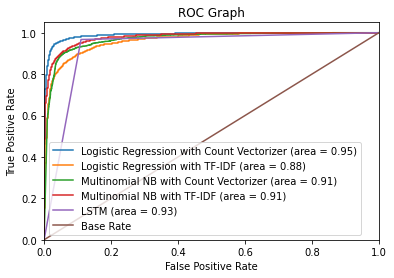

In [560]:
from sklearn.metrics import roc_curve

plt.figure()

# Plot Logistic Regression ROC with Count Vectorizer 
plt.plot(lrc, tprc, label='Logistic Regression with Count Vectorizer (area = %0.2f)' % log_reg_auc_score)

# Plot Logistic Regression ROC with TFIDF
plt.plot(lrt,tprt, label='Logistic Regression with TF-IDF (area = %0.2f)' % log_reg_tfidf_auc_score)

# Plot Multinomial NB with count vectorizer 
plt.plot(fprnbc, tprnbc, label='Multinomial NB with Count Vectorizer (area = %0.2f)' % mnb_cv_auc_score)

# Plot Multinomial NB with TF-IDF
plt.plot(fprnbt, tprnbt, label='Multinomial NB with TF-IDF (area = %0.2f)' % mnb_tfidf_auc_score)

# Plot LSTM 
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_temp_pred, yhat_classes)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.2f})'.format(auc_keras))

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc='best')
plt.show()

### Reporting Table with details on the score -

In [561]:
data = [['Logistic Regression with Count Vectorizer', log_reg_auc_score], 
        ['Logistic Regression with TF-IDF', log_reg_tfidf_auc_score], 
        ['Multinomial NB with Count Vectorizer', mnb_cv_auc_score], 
        ['Multinomial NB with TF-IDF', mnb_tfidf_auc_score],
        ['LSTM', auc_keras]]
df = pd.DataFrame(data, columns = ['ModelName', 'Accuracy Score'])

In [562]:
df.sort_values(by='Accuracy Score', ascending=False)

ModelName  Accuracy Score
0  Logistic Regression with Count Vectorizer        0.954651
4                                       LSTM        0.928429
2       Multinomial NB with Count Vectorizer        0.909528
3                 Multinomial NB with TF-IDF        0.909285
1            Logistic Regression with TF-IDF        0.875636

## Conclusion

There are 20800 records in the training dataset and 5200 records in the test dataset. There are 10413 records, which are labeled as real / valid news and 10387 records are labeled as fake news.

Data Preprocessing, was performed on text – attribute with, remove Line Breaks element, remove new Line element, remove Hyperlink element, remove ampersand, remove greater than sign, remove less than sign, remove non-breaking space, remove Emails, remove new line characters, remove distracting single quotes.

Created the Count Vector Training and Test dataset with split of 70:30 ration for training and test dataset. Created the TFIDF train and test dataset for later in modeling section.

“n-Gram” plots for Unigram, Bigram and Trigram, in the unigram, the most common words after stopword and updating stopword, are “trump”, “will” and “one”. In the Bigram, we can see “united states” and “donald trump” and “new york”. In the trigram, we can see the common words are “new york times”, “president Donald trump ” and “new york city”.

T-Statistics of two independent sentiments sample from the population of fake news articles and real news articles. T-stats =3.249, degree of freedom=20561, cv=1.645, p=0.001, alpha = 0.05.  Comparing the critical values to the t-stat, reject the null hypothesis that the means are equal.  Comparing the p-value to alpha, reject the null hypothesis that the means are equal. 

Models created for Logistics Regression with Count Vectors, Logistics Regression with TF-IDF Vectors, Multinomial Naïve Bayes classifier with Count Vectors with hyper parameter and Multinomial Naïve Bayes classifier with TF-IDF Vectors with hyper parameter. The hyper parameter tuning is done using “GridSearchCV”. The Best parameters resulted as alpha = 0.1. LSTM (long short term memory) neural networks is also used for predicting the fake and legit news classification. 

Best results from the above accuracy score are of – Logistic Regression with Count Vectors with ROC Accuracy is 0.95 or AUC-ROC score of 95%.